In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt 
import numpy as np
import networkx as nx
import seaborn as sns 
# set visualization setting 
sns.set_style("darkgrid")

def network_over_manhattan(laplacian, node_label, label_geo_url, map_geo_url, 
                           subplot, node_sizes = 85, weighted_edges = False): 
    """
    Given the learned graph laplacian for taxi data from the network regression model, visualize the network
    over the map of Manhattan.

    Inputs: 
        - laplacian: the learned graph laplacian from the network regression model. 
        - node_label: the node labels of the graph Laplacisn row/column corresponding to the 13 sites. 
                        This should be a vector of length 13 with entries 1-13.
        - label_geo_url: the url of the geojson file containing the labels of the 13 sites.
        - subplot: the subplot object to use for plotting. 
        - node_sizes: the size of the nodes in the plot. every index should correspond to the right district. 
        - edge_widths: the width of the edges in the plot. 
        - map_geo_url: the url of the geojson file containing the map of Manhattan.
        - save: whether to save the plot.
        - save_url: the url to save the plot to.
    
    Visualizes the network over the map of Manhattan. 
    """

    # read in the geojson files
    label_gdf = gpd.read_file(label_geo_url)
    map_gdf = gpd.read_file(map_geo_url)
    # filter the label to only contain the Manhattan burough
    label_gdf = label_gdf[label_gdf.boroname == "Manhattan"]
    # create the graph from the laplacian 
    num_nodes = laplacian.shape[0]
    G = nx.DiGraph()
    # Add nodes with positions from the GeoPandas DataFrame
    for node in node_label:
        # skip 13 since central park isn't listed in the dataset 
        if node == 13: 
            continue  
        G.add_node(node, pos=(label_gdf[label_gdf.cd == node].geometry.x.values[0], 
                              label_gdf[label_gdf.cd == node].geometry.y.values[0]))
    # add central park goegraphic coordinate manually 
    G.add_node(13, pos=(-73.96552, 40.7833))
    # Add edges from the laplacian matrix, making every non-zero entry an edge
    edges = [(i + 1, j + 1) for i in range(num_nodes) for j in range(num_nodes) if laplacian[i, j] != 0 and i != j]
    # Scale the edge width by the absolute value of the laplacian entry if requested, otherwise set to 1
    if weighted_edges: 
        edge_weights = [laplacian[i, j] for i in range(num_nodes) for j in range(num_nodes) if laplacian[i, j] != 0 and i != j]
        edge_weights = np.abs(edge_weights) / np.max(np.abs(edge_weights)) 
    else: 
        edge_weights = 1
    G.add_edges_from(edges)
    # plot the map of Manhattan
    map_gdf.plot(figsize=(10, 10), edgecolor='w', color = "black", ax = subplot)
    pos = nx.get_node_attributes(G, 'pos')
    # plot the nodes on top of the map
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="orange", ax = subplot)
    # plot the edges on top of the map
    nx.draw_networkx_edges(G, pos, alpha=edge_weights, edge_color = "yellow", ax = subplot)

<class 'networkx.utils.decorators.argmap'> compilation 16:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


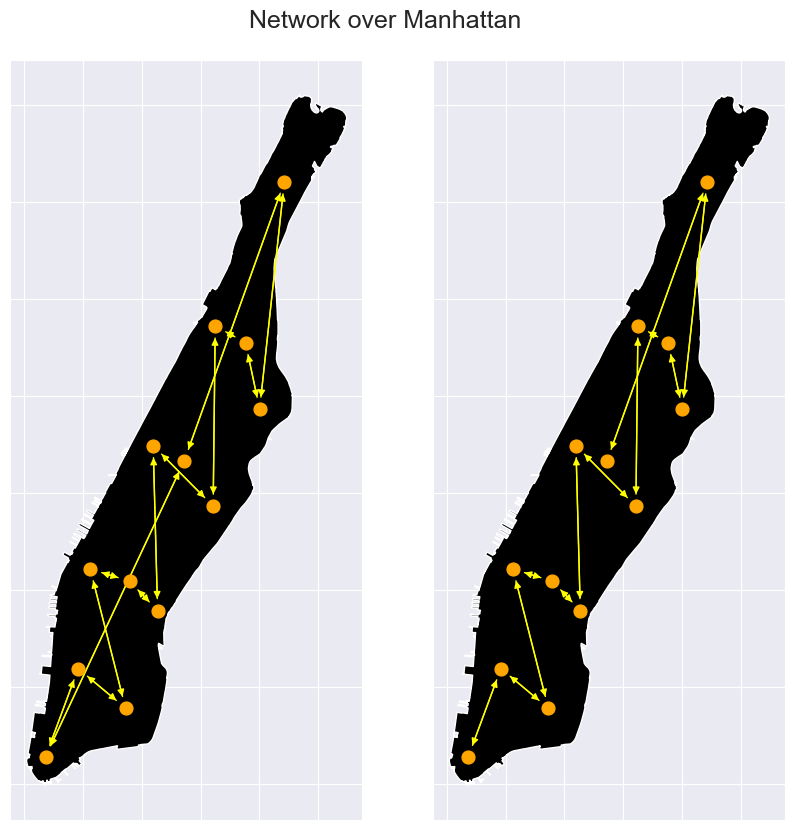

In [7]:
CD_LABEL_URL = "data/nyc-geog/cd_label.geojson" 
MANHATTAN_URL = "data/nyc-geog/manhattan-island.geojson"
PLOT_TITLE = "Network over Manhattan"

cycle = nx.cycle_graph(13)
path = nx.path_graph(13)
cycle_laplacian = nx.laplacian_matrix(cycle).toarray()
path_laplacian = nx.laplacian_matrix(path).toarray()
sample_label = [num for num in range(1, 14)]

fig, ax = plt.subplots(1, 2, figsize = (10, 10))
network_over_manhattan(cycle_laplacian, sample_label, CD_LABEL_URL, MANHATTAN_URL, ax[0], weighted_edges=True)
network_over_manhattan(path_laplacian, sample_label, CD_LABEL_URL, MANHATTAN_URL, ax[1])
fig.suptitle(PLOT_TITLE, fontsize=18)
plt.subplots_adjust(top=0.99) # correct for the weird suptitle spacing

# uncomment below if need to save the plot
# save_path = "network over manhattan"
# plt.savefig(save_path, dpi = 300, bbox_inches='tight')